In [7]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from functools import reduce
import math
from sklearn.mixture import GaussianMixture

In [8]:
# --- Image Loading ---
def load_model(model_path: str) -> YOLO:
    return YOLO(model_path)

def load_image(image_path: str) -> np.ndarray:
    image_path_obj = Path(image_path)
    img = cv2.imread(str(image_path_obj))
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path_obj}")
    return img

# --- Basic Image Processing ---
def sharpen_image(img: np.ndarray) -> np.ndarray:
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def equalize_histogram(img: np.ndarray) -> np.ndarray:
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    return cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

def binarize_with_GMM(image, n_clusters=2):    
    h, w, _ = image.shape
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel = lab[:, :, 0]
    flat = l_channel.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(flat)
    labels = gmm.predict(flat).reshape(h, w)
    dark_cluster = np.argmin(gmm.means_.flatten())
    binary = np.uint8(labels != dark_cluster) * 255
    return binary

def to_grayscale(img: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_blur(img: np.ndarray) -> np.ndarray:
    return cv2.GaussianBlur(img, (5, 5), 0)

# --- Skew Detection (PCA) ---
def detect_skew_pca(gray: np.ndarray, debug: bool = False) -> float:
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0
    
    cnt = max(contours, key=cv2.contourArea)
    data_pts = np.array(cnt, dtype=np.float32).reshape(-1, 2)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=None)
    
    # Tính góc trong không gian radian
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])

    if debug:
        draw_debug_pca(gray, mean, eigenvectors, angle)

    # Trả về góc dưới dạng độ
    return np.degrees(angle)


# --- Skew Detection (Hough) ---
def detect_skew_hough(gray: np.ndarray, visualize: bool = False): 
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)

    if lines is None or len(lines) < 1:
        print("Không tìm thấy đủ đường thẳng")
        return None, None, edges

    # Tính độ dài và lưu lại (x1, y1, x2, y2, length)
    lines_with_length = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.hypot(x2 - x1, y2 - y1)
        lines_with_length.append((x1, y1, x2, y2, length))

    # Sắp xếp theo độ dài giảm dần
    lines_with_length.sort(key=lambda x: x[4], reverse=True)

    # Lấy 2 đoạn dài nhất
    dominant_lines = lines_with_length[:2]

    angles = []
    for x1, y1, x2, y2, _ in dominant_lines:
        angle_rad = math.atan2(y2 - y1, x2 - x1)
        angle_deg = math.degrees(angle_rad)
        # Đưa về khoảng -90 đến +90
        angle_deg = (angle_deg + 180) % 180
        if angle_deg > 90:
            angle_deg -= 180
        angles.append(angle_deg)
        

    if angles:
        median_angle = np.median(angles)
    else:
        median_angle = 0.0

    if visualize:
        vis_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        for x1, y1, x2, y2, _ in dominant_lines:
            cv2.line(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.imshow(vis_img)
        plt.title(f"Detected Hough Lines angle: {median_angle:.2f} degrees")
        plt.axis("off")
        plt.show()
        print(f"Góc nghiêng Hough: {median_angle:.2f} độ")

    return median_angle, edges

def detect_skew_square(gray: np.ndarray, visualize: bool = False):
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # TODO: tìm hình vuông lớn nhất trong contours
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            pts = approx.reshape(4, 2)
            # Sắp xếp các điểm
            rect = order_points(pts)
            
            # Tính góc nghiêng từ top-left và top-right
            (tl, tr, br, bl) = rect
            dx = tr[0] - tl[0]
            dy = tr[1] - tl[1]
            angle_rad = math.atan2(dy, dx)
            angle_deg = math.degrees(angle_rad)
            
            print(f"Góc Square angle: {angle_deg:.2f} độ")
            if visualize:
                vis_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
                cv2.line(vis_img, (int(tl[0]), int(tl[1])), (int(tr[0]), int(tr[1])), (0, 255, 0), 1)
                plt.imshow(vis_img)
                plt.title(f"Detected Square angle: {np.degrees(angle_deg):.2f} degrees")
                plt.axis("off")
                plt.show()

            return angle_deg

    return None

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]       # Top-left
    rect[2] = pts[np.argmax(s)]       # Bottom-right
    rect[1] = pts[np.argmin(diff)]    # Top-right
    rect[3] = pts[np.argmax(diff)]    # Bottom-left

    return rect

def detect_skew_combined(gray: np.ndarray, visualize: bool = False):
    hough_angle, binary = detect_skew_hough(gray, visualize=visualize)
    pca_angle = detect_skew_pca(gray, debug=visualize)
    square_angle = detect_skew_square(gray, visualize=visualize)
    angle = 0.9 * pca_angle + 0.1 * hough_angle
    return (angle, binary) if visualize else angle


# --- Debug Drawing ---
def draw_debug_pca(gray: np.ndarray, mean: np.ndarray, eigenvectors: np.ndarray, angle: float):
    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    center = tuple(np.int32(mean[0]))
    p1 = center + 100 * eigenvectors[0]  # trục chính
    p2 = center + 100 * eigenvectors[1]  # trục phụ

    p1 = tuple(np.int32(p1))
    p2 = tuple(np.int32(p2))

    # Vẽ
    cv2.circle(debug_img, center, 5, (0, 0, 255), -1)
    cv2.line(debug_img, center, p1, (0, 255, 0), 2)  # Principal axis
    cv2.line(debug_img, center, p2, (255, 0, 0), 2)  # Orthogonal axis


    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected PCA angle: {np.degrees(angle):.2f} degrees")
    plt.axis("off")
    plt.show()

# --- Image Rotation ---
def rotate_image_bound(img: np.ndarray, angle: float, mode: str = "inpaint") -> np.ndarray:
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    if mode == "transparent":
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    elif mode == "interpolate":
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    else:
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

def rotate_back(img: np.ndarray, angle: float, mode: str = "inpaint") -> np.ndarray:
    return rotate_image_bound(img, -angle, mode)

# --- Pipeline Steps ---
def correct_skew(img: np.ndarray, debug: bool = False, mode: str = "inpaint") -> tuple[np.ndarray, float]:
    gray = img if len(img.shape) == 2 else to_grayscale(img)
    angle, *_ = detect_skew_combined(gray, visualize=debug)
    rotated = rotate_image_bound(img, angle, mode)
    return rotated, angle

def preprocessing_pipeline(img: np.ndarray, debug: bool = False) -> tuple[np.ndarray, float]:
    pipeline = compose(
        to_blur,
        sharpen_image,
        equalize_histogram,        
        binarize_with_GMM
    )
    processed = pipeline(img)
    corrected, angle = correct_skew(processed, debug=debug)
    # return corrected, angle
    return processed, 0

# --- Inference and Plotting ---
def inference_pipeline(model: YOLO, img: np.ndarray) -> np.ndarray:
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB if len(img.shape) == 2 else cv2.COLOR_BGR2RGB)
    results = model(rgb)
    return results

def full_pipeline(model_path: str, image_path: str, debug: bool = False, mode: str = "inpaint"):
    model = load_model(model_path)
    img = load_image(image_path)
    
    preprocessed_img, angle = preprocessing_pipeline(img, debug=debug)
    results = inference_pipeline(model, preprocessed_img)
    
    result_img = results[0].plot()
    result_img_rotated = rotate_back(result_img, angle, mode)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img_rotated)
    plt.axis("off")
    plt.title(f"Detected + Rotated Back (Angle: {angle:.2f}°)")
    plt.show()

def plot_results(results):
    result_img = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()

# --- Function Composition ---
def compose(*functions):
    return lambda x: reduce(lambda v, f: f(v), functions, x)

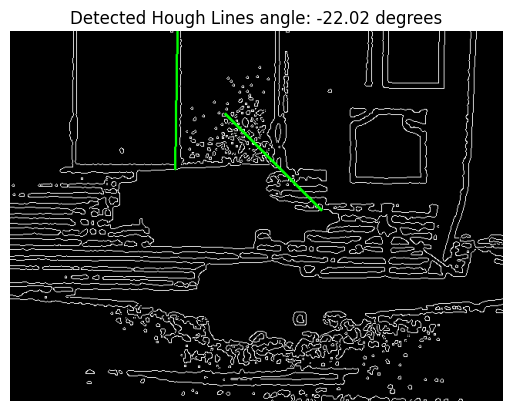

Góc nghiêng Hough: -22.02 độ


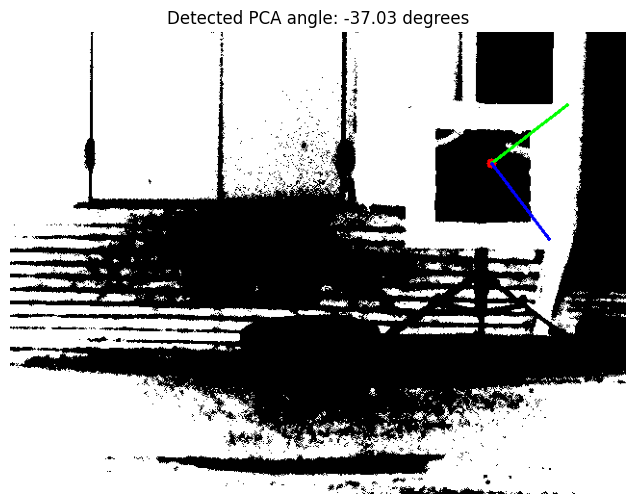

Góc Square angle: 0.00 độ


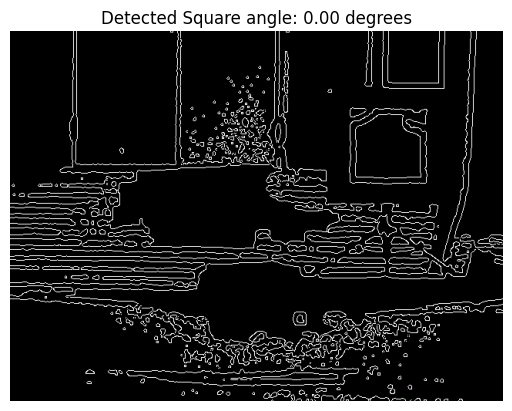


0: 480x640 (no detections), 800.5ms
Speed: 1.9ms preprocess, 800.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


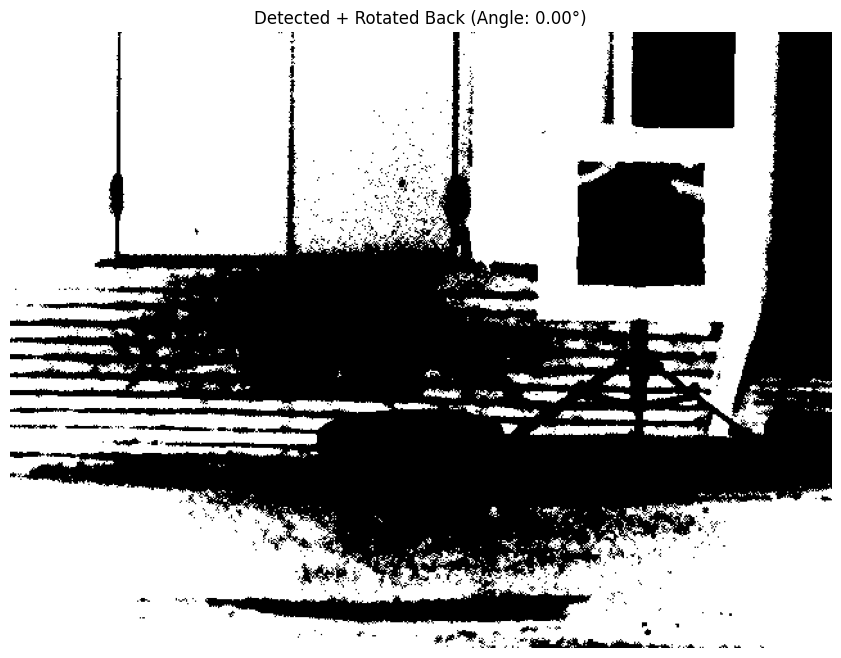

In [ ]:
# --- Main ---
from sympy import false


if __name__ == "__main__":
    model_path = "yolo-models/yolo11x_bia-4.02.pt"
    image_path = "images/bo du lieu bia so 4/bia4 (10).bmp"

    full_pipeline(model_path, image_path, debug=false)


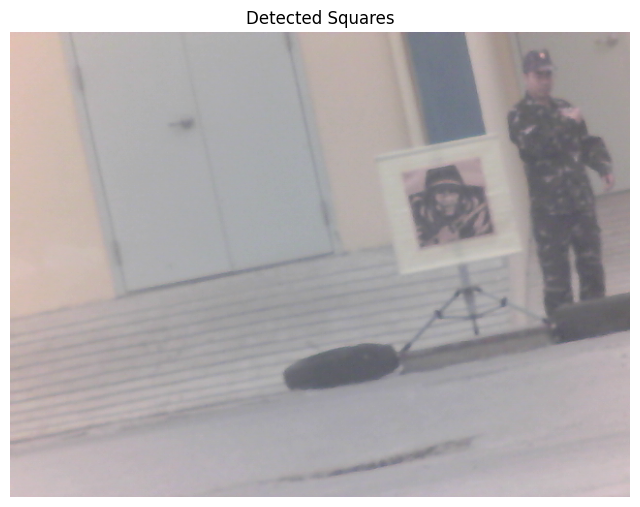

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def read_image(path: str) -> np.ndarray:
    return cv2.imread(path)

def convert_to_hsv(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def extract_white_regions(hsv: np.ndarray) -> np.ndarray:
    # Vùng có độ sáng cao và bão hòa thấp => trắng, xám, vàng nhạt,...
    lower = np.array([0, 0, 180])      # Hue: bất kỳ, Sat: thấp, Value: cao
    upper = np.array([180, 60, 255])   # Cho phép viền hơi ngả màu, không thuần trắng
    return cv2.inRange(hsv, lower, upper)

def convert_to_lab(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

def extract_bright_regions(lab: np.ndarray) -> np.ndarray:
    l_channel = lab[:, :, 0]  # L ranges from 0 (dark) to 255 (bright)
    _, mask = cv2.threshold(l_channel, 200, 255, cv2.THRESH_BINARY)
    return mask

def extract_possible_white_regions(image: np.ndarray, method: str = "hsv") -> np.ndarray:
    if method == "hsv":
        hsv = convert_to_hsv(image)
        return extract_white_regions(hsv)
    elif method == "lab":
        lab = convert_to_lab(image)
        return extract_bright_regions(lab)
    else:
        raise ValueError("Unsupported method.")
    
def extract_bright_regions_gray(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
    return binary    

def find_contours(mask: np.ndarray) -> List[np.ndarray]:
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def is_square_contour(contour: np.ndarray, epsilon_ratio=0.02, min_area=1000) -> bool:
    approx = cv2.approxPolyDP(contour, epsilon_ratio * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    return len(approx) == 4 and area > min_area and cv2.isContourConvex(approx)

def draw_contours(image: np.ndarray, contours: List[np.ndarray]) -> np.ndarray:
    return cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

def bgr_to_rgb(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def process_image(path: str) -> np.ndarray:
    image = read_image(path)
    hsv = convert_to_hsv(image)
    # mask = extract_possible_white_regions(image, method="lab")  # "hsv" "lab"
    mask = extract_bright_regions_gray(image)
    contours = find_contours(mask)
    square_contours = [cnt for cnt in contours if is_square_contour(cnt)]
    result = draw_contours(image, square_contours)
    return result

def show_image_matplotlib(image: np.ndarray, title: str = "Result") -> None:
    rgb_image = bgr_to_rgb(image)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Example usage:
if __name__ == "__main__":
    result = process_image("images/bo du lieu bia so 4/bia4 (1).bmp")    
    show_image_matplotlib(result, "Detected Squares")

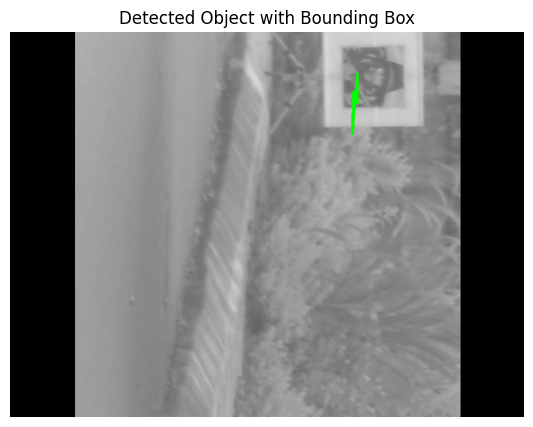

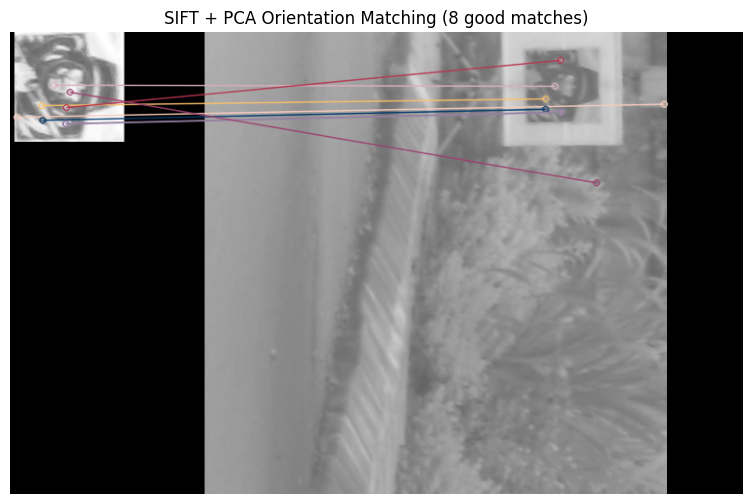

In [94]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from typing import Tuple, List
import matplotlib.pyplot as plt


def read_gray_image(path: str) -> np.ndarray:
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def apply_pca_orientation(img: np.ndarray) -> np.ndarray:
    """Sử dụng PCA để xoay ảnh về hướng chính"""
    coords = np.column_stack(np.where(img > 0))  # non-zero pixels
    if len(coords) < 2:
        return img
    pca = PCA(n_components=2)
    pca.fit(coords)
    angle = np.arctan2(pca.components_[0, 1], pca.components_[0, 0]) * 180 / np.pi
    center = tuple(np.array(img.shape[::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(img, rot_mat, img.shape[::-1], flags=cv2.INTER_LINEAR)
    return rotated


def extract_keypoints_descriptors(img: np.ndarray, method: str = 'SIFT') -> Tuple[List[cv2.KeyPoint], np.ndarray]:
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    elif method == 'ORB':
        detector = cv2.ORB_create()
    else:
        raise ValueError("Method must be 'SIFT' or 'ORB'")
    return detector.detectAndCompute(img, None)


def match_descriptors(desc1: np.ndarray, desc2: np.ndarray, method: str = 'SIFT', ratio: float = 0.75):
    if method == 'SIFT':
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:  # ORB
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    raw_matches = matcher.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in raw_matches if m.distance < ratio * n.distance]
    return good_matches


def draw_matches(img1, kp1, img2, kp2, matches):
    return cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

def get_homography_and_box(kp1, kp2, matches, template_shape, min_matches=4):
    if len(matches) < min_matches:
        return None, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        return None, None

    h, w = template_shape
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)
    return H, transformed_corners

def draw_bounding_box(image: np.ndarray, corners: np.ndarray) -> np.ndarray:
    boxed = image.copy()
    corners = np.int32(corners)
    cv2.polylines(boxed, [corners], isClosed=True, color=(0, 255, 0), thickness=2)
    return boxed

def pca_rotation_matching(template_path: str, image_path: str, method: str = 'SIFT'):
    # Đọc ảnh
    template = read_gray_image(template_path)
    image = read_gray_image(image_path)

    # Chuẩn hóa hướng bằng PCA
    template_rot = apply_pca_orientation(template)
    image_rot = apply_pca_orientation(image)

    # Trích xuất đặc trưng
    kp1, desc1 = extract_keypoints_descriptors(template_rot, method)
    kp2, desc2 = extract_keypoints_descriptors(image_rot, method)

    # Matching
    good_matches = match_descriptors(desc1, desc2, method)

    # Tìm homography và vẽ bounding box
    H, box = get_homography_and_box(kp1, kp2, good_matches, template_rot.shape)
    if box is not None:
        boxed_img = draw_bounding_box(cv2.cvtColor(image_rot, cv2.COLOR_GRAY2BGR), box)
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
        plt.title('Detected Object with Bounding Box')
        plt.axis('off')
        plt.show()

    # Vẽ kết quả
    matched_img = draw_matches(template_rot, kp1, image_rot, kp2, good_matches)
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_img)
    plt.title(f'{method} + PCA Orientation Matching ({len(good_matches)} good matches)')
    plt.axis('off')
    plt.show()


# 🔧 Example usage
if __name__ == "__main__":
    pca_rotation_matching("images/templates/bia4.png", "images/bo du lieu bia so 4/bia4 (31).bmp", method='SIFT')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def high_pass_filter(shape, radius=10):
    rows, cols = shape
    mask = np.ones((rows, cols), dtype=np.float32)
    center = (cols // 2, rows // 2)
    cv2.circle(mask, center, radius, 0, -1)
    return mask


def log_polar_transform(image, center, M=60):
    max_radius = np.linalg.norm(np.array(image.shape[::-1]) / 2)
    flags = cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS
    log_polar = cv2.logPolar(image, center, M, flags)
    return log_polar


def compute_fft(image):
    image_float = np.float32(image)
    dft = cv2.dft(image_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    return dft


def compute_log_magnitude_spectrum(fft_image):
    magnitude, _ = cv2.cartToPolar(fft_image[:, :, 0], fft_image[:, :, 1])
    log_mag = np.log1p(magnitude)
    return log_mag


def match_rotation_scale(template, target, highpass_radius=10):
    center = (template.shape[1] // 2, template.shape[0] // 2)

    # Chuyển ảnh sang miền log-polar
    M = 60  # log base scale
    template_lp = log_polar_transform(template, center, M)
    target_lp = log_polar_transform(target, center, M)

    # Áp dụng high-pass filter để loại bỏ DC component
    hpf = high_pass_filter(template.shape, radius=highpass_radius)
    template_lp = np.float32(template_lp) * hpf
    target_lp = np.float32(target_lp) * hpf
    
    # FFT
    fft_template = compute_fft(template_lp)
    fft_target = compute_fft(target_lp)

    # Cross-power spectrum
    conjB = cv2.mulSpectrums(fft_template, fft_target, flags=0, conjB=True)
    denom = np.sqrt((conjB ** 2).sum(axis=2))
    denom[denom == 0] = 1e-10  # tránh chia cho 0
    cps = conjB / denom[:, :, np.newaxis]

    # Inverse FFT để tìm peak
    result = cv2.idft(cps, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    _, _, _, max_loc = cv2.minMaxLoc(result)

    # Suy ra rotation + scale
    rows, cols = template.shape
    shift_y, shift_x = max_loc
    angle = 360.0 * shift_y / rows
    log_scale = shift_x / cols
    scale = np.exp(log_scale)

    return angle, scale


def rotate_and_scale_image(image, angle, scale, center=None):
    if center is None:
        center = (image.shape[1] / 2, image.shape[0] / 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0 / scale)
    result = cv2.warpAffine(image, M, image.shape[::-1], flags=cv2.INTER_LINEAR)
    return result


def fft_match(template, image):
    angle, scale = match_rotation_scale(template, image)
    aligned_template = rotate_and_scale_image(template, angle, scale)

    # Sử dụng matchTemplate để tìm vị trí sau khi scale/rotate
    res = cv2.matchTemplate(image, aligned_template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(res)

    h, w = aligned_template.shape
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return image, aligned_template, top_left, bottom_right, angle, scale, max_val


def visualize_result(image, template, top_left, bottom_right, angle, scale, score):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)
    plt.figure(figsize=(10, 5))
    plt.imshow(image_rgb[..., ::-1])
    plt.title(f"FMT Match — Angle: {angle:.2f}°, Scale: {scale:.2f}, Score: {score:.3f}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    template = cv2.imread("images/templates/bia4.png", cv2.IMREAD_GRAYSCALE)
    image = cv2.imread("images/bo du lieu bia so 4/bia4 (31).bmp", cv2.IMREAD_GRAYSCALE)

    image, aligned_template, top_left, bottom_right, angle, scale, score = fft_match(template, image)
    visualize_result(image, aligned_template, top_left, bottom_right, angle, scale, score)


ValueError: operands could not be broadcast together with shapes (480,640) (114,121) 

: 